# Verification of the geostatistics implementation

This notebook is dedicated to check the implementation and the correctness of the first derivative of two classic regularization operators: Tikhonov and Total Variations. The numerical check is performed by a finite difference approximation of the first derivative.

- Import the required modules

In [1]:
import logging
import os
from pathlib import Path

import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pyrtid
from matplotlib.colors import LogNorm
from pyrtid.inverse import (
    AdjustableParameter,
    ParameterName,
)
from pyrtid.inverse.regularization import (
    ConstantPriorTerm,
    DenseCovarianceMatrix,
    FFTCovarianceMatrix,
    GeostatisticalRegularizator,
    MeanPriorTerm,
    SparseInvCovarianceMatrix,
    eigen_factorize_cov_mat,
)
from pyrtid.utils import gen_random_ensemble

- Check package/software versions

In [2]:
logging.info(f"pyrtid.__version__ = {pyrtid.__version__}")
logging.info(f"nested_grid_plotter.__version__ = {nested_grid_plotter.__version__}")

- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Set-up logging level

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a test")

INFO:root:this is a test


- Define some configurations for the plots

In [6]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

# Loading test data

With finite difference, the parameters are defined at the interface of two nodes. It means that for an `n*m` grid, the output gradient will be `(n-1)*(m-1)`

Let's start by defining a 2D grid with some interfaces.

In [7]:
nx = 100
ny = 75
nz = 1
dx = 10  # m
dy = 10  # m
dz = 1
shape = (nx, ny)

x = np.linspace(0.0 + dx / 2.0, nx * dx - dx / 2.0, nx)
y = np.linspace(0.0 + dy / 2.0, ny * dy - dy / 2.0, ny)
XX, YY = np.meshgrid(x, y)
pts = np.hstack((XX.ravel()[:, np.newaxis], YY.ravel()[:, np.newaxis]))

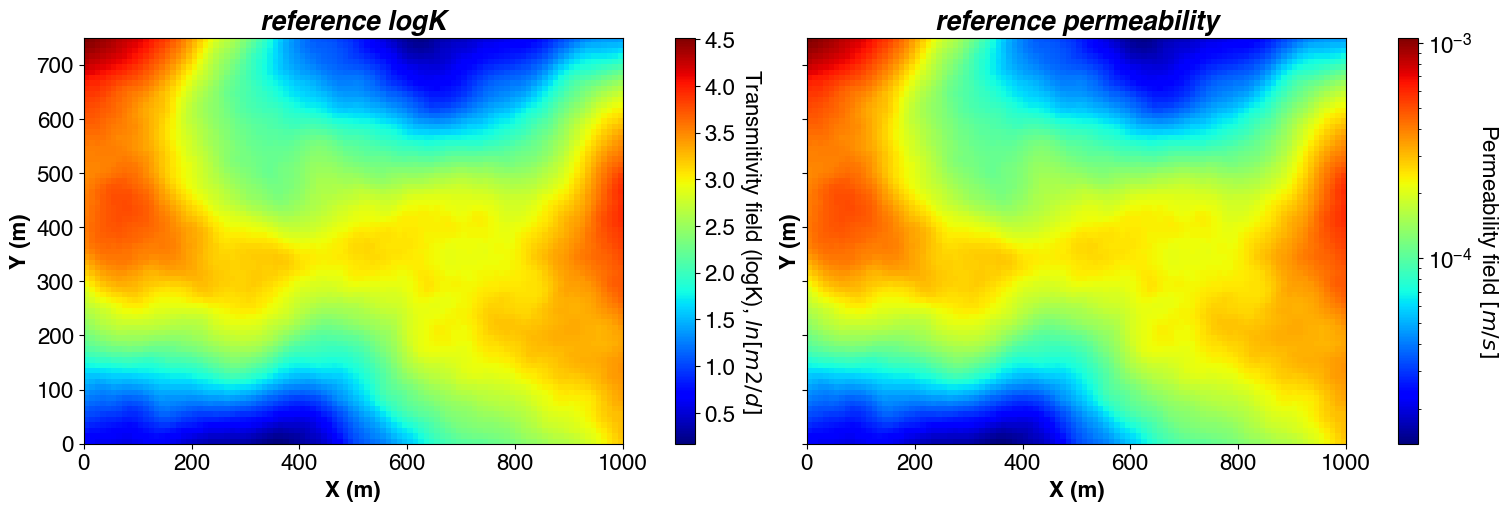

In [8]:
def log_transmitivity_to_permeability(x: NDArrayFloat) -> NDArrayFloat:
    """Convert a transmitivity in ln[m2/d] to a permeability in [m/s]."""
    return np.exp(x) / 3600 / 24


def permeability_to_log_transmitivity(x: NDArrayFloat) -> NDArrayFloat:
    """Convert a permeability in [m/s] to a transmitivity in ln[m2/d]."""
    return np.log(x * 3600 * 24)


logT_reference: NDArrayFloat = np.loadtxt("reference_logK.txt")
perm_reference = log_transmitivity_to_permeability(logT_reference)
perm_reference_2d = perm_reference.reshape(ny, nx).T
logT_reference_3d = logT_reference.reshape(nz, ny, nx)
logT_reference_2d = logT_reference_3d[0, :, :].T

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Plot the permeability
ngp.multi_imshow(
    axes=[plotter.get_axis("ax1-1")],
    fig=plotter.fig,
    data={"reference logK": logT_reference_2d},
    cbar_title="Transmitivity field (logK), $ln[m2/d]$",
    imshow_kwargs={"cmap": plt.get_cmap("jet"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

ngp.multi_imshow(
    axes=[plotter.get_axis("ax1-2")],
    fig=plotter.fig,
    data={"reference permeability": perm_reference_2d},
    cbar_title="Permeability field $[m/s]$",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "norm": LogNorm(),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

# Generate another field with gstools

In [9]:
ny

75

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


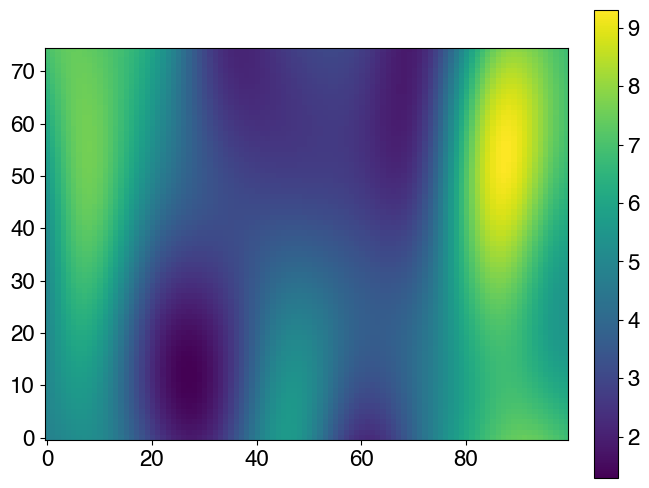

In [10]:
import gstools as gs

# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 194987

min_val = 0  # 32 ppm
max_val = 10  # 700 ppm
# Compute the mean and the standard deviation that the distribution should have so that
# <99% of the values are between min and max ~ 6 sigmas
mean = (max_val + min_val) / 2
stdev = (max_val - min_val) / 2 / 3  # std ~ 1/6 of the distribution interval
len_scale = (12, 35, 5)

true_min_t_cinet = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    seed=seed,
    model_kwargs={"nugget": 0.0},
)[0, :, :, 0]

# Initial estimate = an homogeneous value
estimate_min_t_cinet = np.ones((nx, ny)) * 200  # 200 ppm


plt.imshow(true_min_t_cinet.T, origin="lower")
plt.colorbar()

In [11]:
logT_reference_2d = true_min_t_cinet

- Some kernels definition

In [12]:
# For now we use the exact parameters, we will complexify a bit later
prior_std = 1.0
len_scale: NDArrayFloat = np.array([250.0, 250.0, 1.0])


# Exponential covariance model
def exponential_kernel(r: float) -> NDArrayFloat:
    return (prior_std**2) * np.exp(-r)


# Gaussian covariance model
def gaussian_kernel(r: float) -> NDArrayFloat:
    return (prior_std**2) * np.exp(-(r**2))

In [14]:
param = AdjustableParameter(
    name=ParameterName.PERMEABILITY,
    lbounds=1e-6,
    ubounds=0.1,
    values=logT_reference_2d,
)

# Dense covariance matrix (expensive)

INFO:root:loss_reg_dense = 225.1468500580889
INFO:root:loss_reg_dense_gradient_mean = 0.004068221034432263
INFO:root:mean hydraulic conductivity field (m2/d) = 4.688552745500166


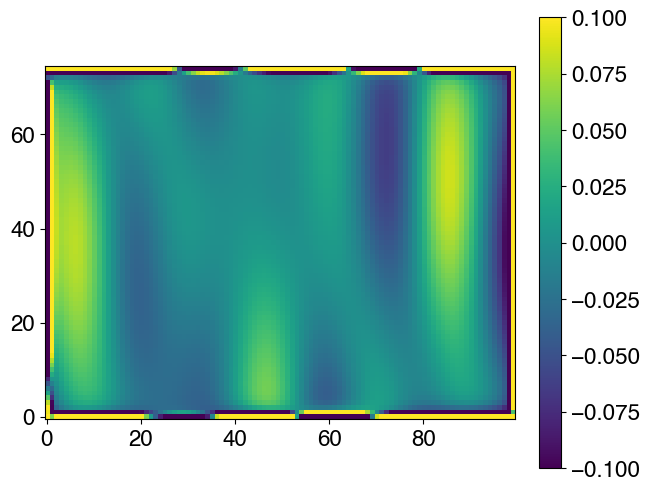

In [15]:
# Create a dense instance
cov_mat_dense = DenseCovarianceMatrix(
    pts=pts, kernel=exponential_kernel, len_scale=len_scale
)

reg_dense = GeostatisticalRegularizator(cov_mat_dense)

loss_reg_dense = reg_dense.eval_loss(param.values)
loss_reg_dense_gradient = reg_dense.eval_loss_gradient(param.values)
logging.info(f"loss_reg_dense = {loss_reg_dense}")
logging.info(f"loss_reg_dense_gradient_mean = {np.mean(loss_reg_dense_gradient)}")
logging.info(f"mean hydraulic conductivity field (m2/d) = {np.mean(logT_reference_2d)}")

plt.imshow(
    loss_reg_dense_gradient.T,
    origin="lower",
    # cmap=plt.get_cmap("jet"),
    vmin=-0.1,
    vmax=0.1,
)
plt.colorbar()

loss_reg_dense = 149.64077203081806
loss_reg_dense_gradient_mean = 0.00022627136728595426


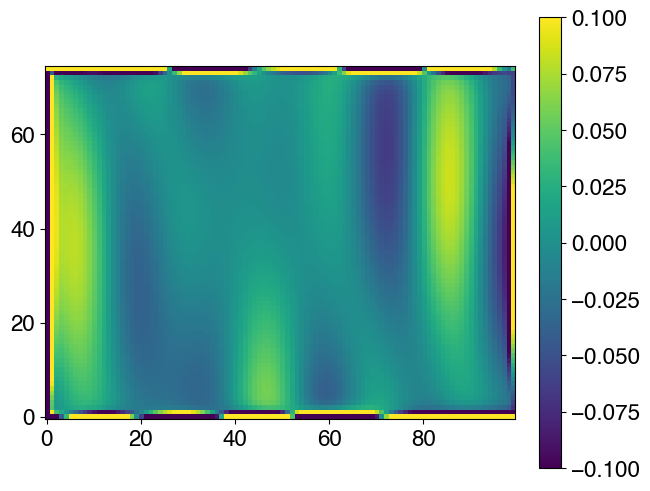

In [16]:
reg_dense = GeostatisticalRegularizator(cov_mat_dense)

residuals = param.values - np.mean(param.values)

loss_reg_dense = reg_dense.eval_loss(residuals)
loss_reg_dense_gradient = reg_dense.eval_loss_gradient(residuals)
print(f"loss_reg_dense = {loss_reg_dense}")
print(f"loss_reg_dense_gradient_mean = {np.mean(loss_reg_dense_gradient)}")


plt.imshow(
    loss_reg_dense_gradient.T,
    origin="lower",
    # cmap=plt.get_cmap("jet"),
    vmin=-0.1,
    vmax=0.1,
)
plt.colorbar()

## Eigen decomposition

In [17]:
reg_dense.cov_m.shape

(7500, 7500)

- with 64 componentents

In [18]:
cov_mat_dense_eigen_64 = eigen_factorize_cov_mat(cov_mat_dense, n_pc=64)

INFO:root:Eigendecomposition of Prior Covariance
INFO:root:- time for eigendecomposition with k = 64 is 11 sec
INFO:root:- 1st eigv : 1782.68, 64-th eigv : 7.91328, ratio: 0.00443898


In [19]:
reg_dense_eigen_64 = GeostatisticalRegularizator(
    cov_mat_dense_eigen_64, prior=MeanPriorTerm()
)
print(f"loss_reg_dense_eigen_64 = {reg_dense_eigen_64.eval_loss(param.values)}")

loss_reg_dense_eigen_64 = 126.37388068788592


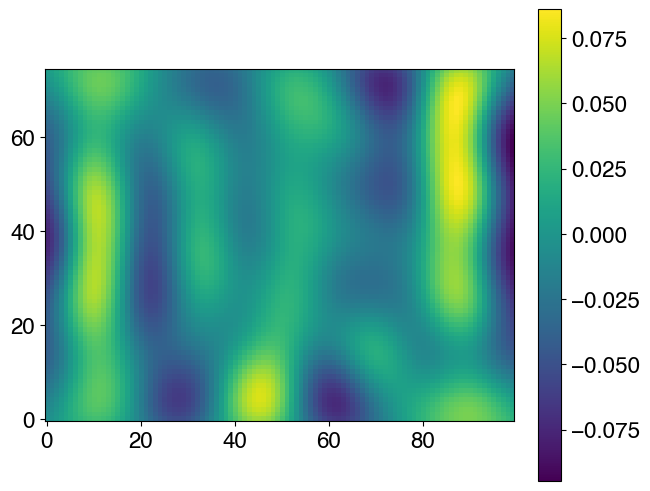

In [20]:
plt.imshow(reg_dense_eigen_64.eval_loss_gradient(param.values).T, origin="lower")
plt.colorbar()

- with 32 componentents

In [21]:
cov_mat_dense_eigen_32 = eigen_factorize_cov_mat(cov_mat_dense, n_pc=32)

INFO:root:Eigendecomposition of Prior Covariance
INFO:root:- time for eigendecomposition with k = 32 is 6 sec
INFO:root:- 1st eigv : 1782.68, 32-th eigv : 22.0615, ratio: 0.0123755


In [22]:
reg_dense_eigen_32 = GeostatisticalRegularizator(
    cov_mat_dense_eigen_32, prior=MeanPriorTerm()
)
print(f"loss_reg_dense_eigen_32 = {reg_dense_eigen_32.eval_loss(param.values)}")

loss_reg_dense_eigen_32 = 89.54115743149012


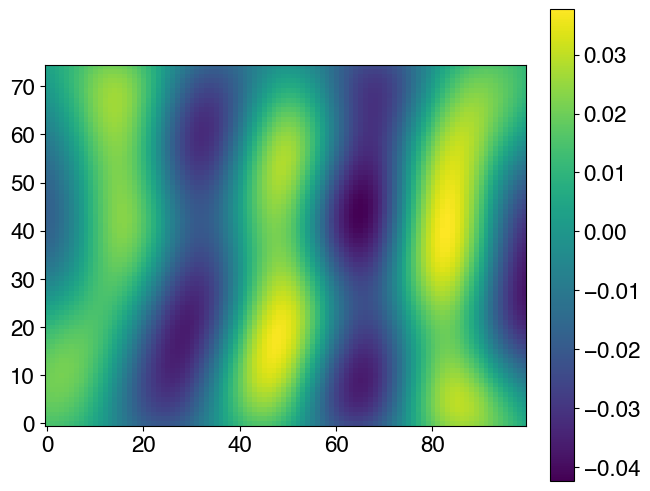

In [23]:
plt.imshow(reg_dense_eigen_32.eval_loss_gradient(param.values).T, origin="lower")
plt.colorbar()

## Check gradient correctness

- We don't test the dense one since it is very expensive and long

# FFT Covariance matrix

In [24]:
cov_mat_fft = FFTCovarianceMatrix(
    kernel=exponential_kernel,
    domain_shape=(nx, ny),
    mesh_dim=(dx, dy),
    len_scale=len_scale,
)

INFO:root:Tree building time = 0.0020170211791992188
INFO:root:Nearest neighbor computation time = 0.22551965713500977


INFO:root:loss_reg_fft = 149.64077203080555
INFO:root:loss_reg_dense_gradient_mean = -9.473903143468003e-19
INFO:root:mean hydraulic conductivity field (m2/d) = 4.688552745500166


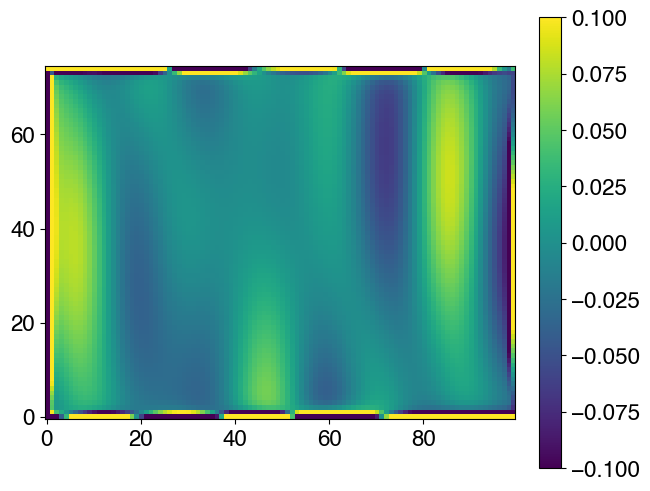

In [ ]:
reg_fft = GeostatisticalRegularizator(cov_mat_fft, prior=MeanPriorTerm())
loss_reg_fft = reg_fft.eval_loss(param.values)
loss_reg_fft_gradient = reg_fft.eval_loss_gradient(param.values)
logging.info(f"loss_reg_fft = {loss_reg_fft}")
logging.info(f"loss_reg_dense_gradient_mean = {np.mean(loss_reg_fft_gradient)}")
logging.info(f"mean hydraulic conductivity field (m2/d) = {np.mean(logT_reference_2d)}")

plt.imshow(loss_reg_fft_gradient.T, origin="lower", vmin=-0.1, vmax=0.1)
plt.colorbar()

## Eigen decomposition

In [ ]:
cov_mat_fft_eigen_64 = eigen_factorize_cov_mat(cov_mat_fft, n_pc=64)

INFO:root:Eigendecomposition of Prior Covariance
INFO:root:- time for eigendecomposition with k = 64 is 2 sec
INFO:root:- 1st eigv : 1782.68, 64-th eigv : 7.91328, ratio: 0.00443898


INFO:root:loss_reg_fft = 126.37388068788579
INFO:root:loss_reg_dense_gradient_mean = -1.1842378929335004e-19
INFO:root:mean hydraulic conductivity field (m2/d) = 4.688552745500166


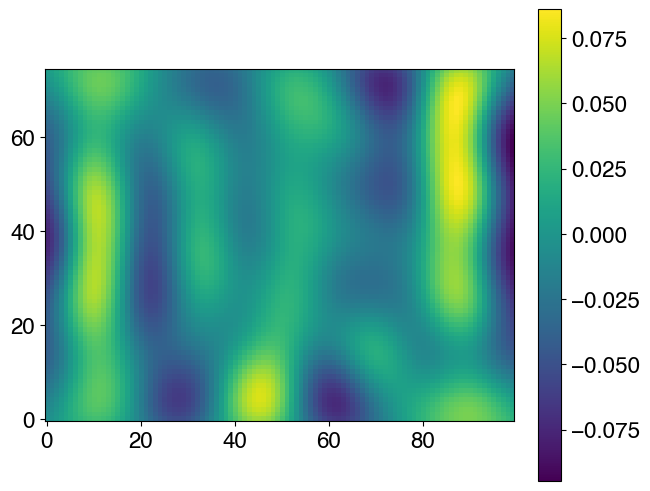

In [ ]:
reg_fft_eigen_64 = GeostatisticalRegularizator(
    cov_mat_fft_eigen_64, prior=MeanPriorTerm()
)

loss_reg_fft_eigen64 = reg_fft_eigen_64.eval_loss(param.values)
loss_reg_fft_eigen64_gradient = reg_fft_eigen_64.eval_loss_gradient(param.values)
logging.info(f"loss_reg_fft = {loss_reg_fft_eigen64}")
logging.info(f"loss_reg_dense_gradient_mean = {np.mean(loss_reg_fft_eigen64_gradient)}")
logging.info(f"mean hydraulic conductivity field (m2/d) = {np.mean(logT_reference_2d)}")

plt.imshow(reg_fft_eigen_64.eval_loss_gradient(param.values).T, origin="lower")
plt.colorbar()

In [ ]:
cov_mat_fft_eigen_32 = eigen_factorize_cov_mat(cov_mat_fft, n_pc=32)

INFO:root:Eigendecomposition of Prior Covariance
INFO:root:- time for eigendecomposition with k = 32 is 1 sec
INFO:root:- 1st eigv : 1782.68, 32-th eigv : 22.0615, ratio: 0.0123755


INFO:root:loss_reg_fft = 89.54115743149028
INFO:root:loss_reg_dense_gradient_mean = 7.105427357601002e-19
INFO:root:mean hydraulic conductivity field (m2/d) = 4.688552745500166


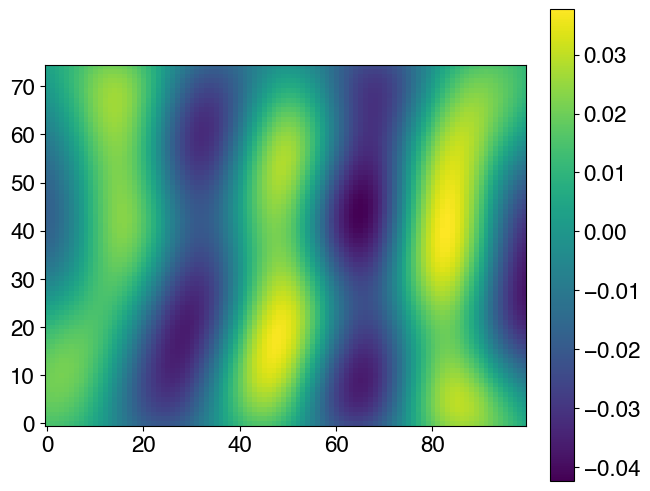

In [ ]:
reg_fft_eigen_32 = GeostatisticalRegularizator(
    cov_mat_fft_eigen_32, prior=MeanPriorTerm()
)

loss_reg_fft_eigen32 = reg_fft_eigen_32.eval_loss(param.values)
loss_reg_fft_eigen32_gradient = reg_fft_eigen_32.eval_loss_gradient(param.values)
logging.info(f"loss_reg_fft = {loss_reg_fft_eigen32}")
logging.info(f"loss_reg_dense_gradient_mean = {np.mean(loss_reg_fft_eigen32_gradient)}")
logging.info(f"mean hydraulic conductivity field (m2/d) = {np.mean(logT_reference_2d)}")

plt.imshow(reg_fft_eigen_32.eval_loss_gradient(param.values).T, origin="lower")
plt.colorbar()

# Test 3 D -> pour Nico Seigneur

In [ ]:
nx = 20
ny = 20
nz = 66
dx = 5
dy = 5
dz = 1

n_nodes = nx * ny * nz

len_scale = (50.0, 50.0, 10.0)

In [ ]:
# fft_test = FFTCovarianceMatrix(kernel=gaussian_kernel, mesh_dim=(dx, dy, dz), domain_shape=(nx, ny,nz), len_scale=len_scale)

In [ ]:
# fft_test_eigen = eigen_factorize_cov_mat(fft_test, n_pc=32, random_state=np.random.default_rng(2739))

# Test with SPDE

In [ ]:
import gstlearn as gl
import numpy as np
import scipy.sparse as sc

In [ ]:
model = gl.Model.createFromParam(
    gl.ECov.BESSEL_K, param=0.5, ranges=[250.0, 250, 1.0], flagRange=False
)

- Note: note possible to use 2D grids, so we use a trick for now

In [ ]:
gr = gl.DbGrid.create([100, 75, 3], [10.0, 10.0, 1.0])

In [ ]:
mesh = gl.MeshETurbo(gr)

- Precision matrix object

In [ ]:
A = gl.PrecisionOpCs(mesh, model, 0, gl.EPowerPT.ONE, False)

In [ ]:
Qt = gl.csToTriplet(A.getQ())
Q = sc.csc_matrix(
    (np.array(Qt.values), (np.array(Qt.rows), np.array(Qt.cols))),
    shape=(Qt.nrows, Qt.ncols),
)

- Check the sparcity

In [ ]:
logging.info(f"sparcity = {Q.getnnz() / np.prod(Q.shape) * 100:.4f}%")

INFO:root:sparcity = 0.0891%


In [ ]:
spinv_cov_mat = SparseInvCovarianceMatrix(Q)

NameError: name 'Q' is not defined

In [41]:
reg_sparse_inv_cov = GeostatisticalRegularizator(
    spinv_cov_mat, prior=ConstantPriorTerm(np.array([2.5]))
)

NameError: name 'spinv_cov_mat' is not defined

- Need to increase the size of m by 3

In [74]:
spinv_cov_mat.inv_mat.shape

(22500, 22500)

In [39]:
param.values[:, ::-1].ravel(order="F").size

7500

In [40]:
spinv_cov_mat.solve(param.values[:, ::-1].ravel(order="F")).shape

NameError: name 'spinv_cov_mat' is not defined

In [ ]:
reg_sparse_inv_cov.eval_loss(param.values)

(7500,)
(22500, 1)


948.657537219986

In [ ]:
grad = reg_sparse_inv_cov.eval_loss_gradient(param.values).reshape(param.values.shape)

(7500,)
(22500, 1)


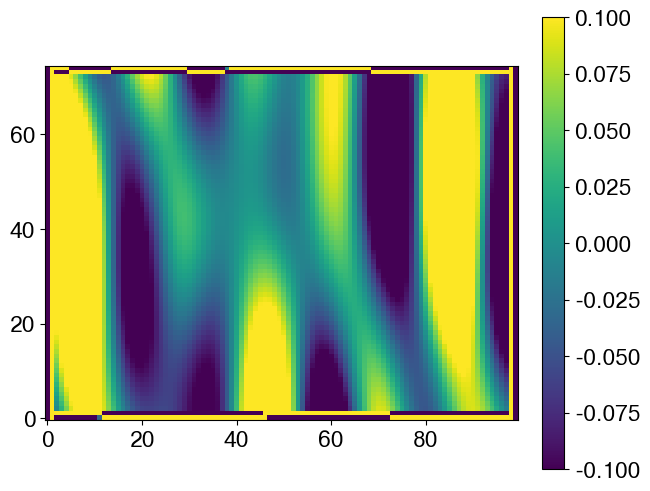

In [ ]:
plt.imshow(grad.T, origin="lower", vmin=-0.1, vmax=0.1)
plt.colorbar()

In [ ]:
from pyrtid.inverse.regularization.covariances import CallBack, CovarianceMatrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lgmres


class SparseInvCovarianceMatrix2(CovarianceMatrix):
    """
    Represents a sparse inverse covariance matrix.

    Works for arbitrary kernels on irregular grids.
    """

    def __init__(
        self,
        inv_mat: csc_matrix,
    ) -> None:
        self.inv_mat = inv_mat

    def _matvec(self, x: NDArrayFloat) -> NDArrayFloat:
        """Return the covariance matrix times the vector x."""
        raise self.solve(x)

    def _rmatvec(self, x: NDArrayFloat) -> NDArrayFloat:
        """Return the covariance matrix conjugate transpose times the vector x."""
        raise self.solve(x)

    def solve(self, x: NDArrayFloat) -> NDArrayFloat:
        """Return $Q^{-1} x."""
        return self.inv_mat.dot(x)

    def solve(
        self, b: NDArrayFloat, tol: float = 1e-12, maxiter: int = 1000
    ) -> NDArrayFloat:
        """Solve Ax = b, with A, the current covariance matrix instance."""
        residual = CallBack()
        x, info = lgmres(
            self,
            b,
            tol=tol,
            maxiter=maxiter,
            callback=residual,
            # M=self.preconditioner, -> LU ??? See if LU is a good one
        )
        self.solvmatvecs += residual.itercount
        return x

In [ ]:
n_params = int(Q.shape[0] / 3)
Q2 = Q.tolil(copy=True)[n_params:-n_params, n_params:-n_params].tocsc()
Q2

<7500x7500 sparse matrix of type '<class 'numpy.float64'>'
	with 95754 stored elements in Compressed Sparse Column format>

In [ ]:
spinv_cov_mat2 = SparseInvCovarianceMatrix2(Q2)
reg_sparse_inv_cov2 = GeostatisticalRegularizator(
    spinv_cov_mat2, drift_matrix=ConstantDriftMatrix(pts), beta=np.array([2.5])
)

In [ ]:
spinv_cov_mat2.solve(param.values[:, ::-1].ravel(order="F")).shape

(7500,)

In [ ]:
reg_sparse_inv_cov2.eval_loss(param.values)

948.657537219986

In [ ]:
grad2 = reg_sparse_inv_cov2.eval_loss_gradient(param.values).reshape(param.values.shape)

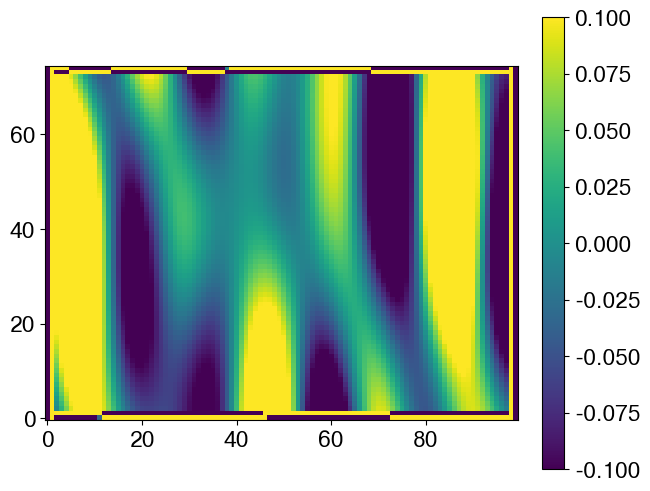

In [ ]:
plt.imshow(grad.T, origin="lower", vmin=-0.1, vmax=0.1)
plt.colorbar()